# Germany Housing and Renting Prices

## A. Introduction

### A.1. Description & Disscusion of the Background

Germany is one of the most important countries not only in Europe but also in the whole world. According to the overall ranking of Best Countries measure global performance, Germany is the fourth Best Country of the World in 2020. <a href="https://www.usnews.com/news/best-countries/overall-rankings![image.png](attachment:image.png)"> (US-News)</a>

*“Germany, the most populous nation in the European Union, possesses one of the largest economies in the world and has seen its role in the international community grow steadily since reunification. The Central European country borders nine nations, and its landscape varies, from the northern plains that reach to the North and Baltic seas to the Bavarian Alps in the south. (Usnews, s. 2020)”*

Nowadays, one of the most important investment items for both individual investors and companies is real estate investments. Considering the importance of Germany and Housing Trade together, I decided to make an enlightening analysis for those who are considering to trade housing in Germany. 

The aim of this study is to show the investors in which cities they can invest in which price ranges. In addition, they will have the opportunity to compare their investment with the average rental fee.

### A.2. Defining Data

#### In this analysis, to be used the Datasets listed below.

* Germany Housing - Rent and Price data set - Apr 20 from <a href="https://www.kaggle.com/phanindraparashar/germany-housing-rent-and-price-data-set-apr-20/">Kaggle</a>
 
       Kaggle is one of the popular platforms that offers sample data sets and sample data studies on data science and data analysis.Kaggle allows users to find and publish data sets, explore and build models in a web-based data-science environment, work with other data scientists and machine learning engineers, and enter competitions to solve data science challenges. 
       
       In the kaggle data set used in the analysis; It is possible to reach many parameters such as prices, number of rooms, usage area, construction date, heating system according to the states, cities and districts where the houses in Germany are located.
       
* <a href="https://www.suche-postleitzahl.org/downloads">Spape File and Locations of Cities </a>

        The shapefile format is a digital vector storage format for storing geometric location and associated attribute information. In order to visualize price density map of Germany this data set was needed. Furthermore, geometrical locations of districts was used for clustering analysis.
        

* Forsquare API was used to get the most common venues of given Borough of Cities.       

## B. Cleaning and Preparing Data for Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

import json
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import geocoder
from geopy.geocoders import Nominatim

import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn')
%matplotlib inline

In [2]:
'''to see all columns and rows, unless want to constrain it.'''

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
'''loading datasets'''

df_price = pd.read_csv('apr20_price_33_col.csv', low_memory=False)
df_rent = pd.read_csv('apr20_rent_33_col.csv', low_memory=False)
plz_shape_df = gpd.read_file('plz-gebiete.shp/plz-gebiete.shp', dtype={'plz': str})
de_zip_lat = pd.read_csv('zip_lat_lang.csv')
de_plz_ort = pd.read_csv('zuordnung_plz_ort.csv')

In [4]:
df_price.head(3)

,Unnamed: 0,obj_regio1,obj_heatingType,obj_cId,obj_newlyConst,obj_pricetrend,obj_yearConstructed,obj_pricetrendbuy,obj_firingTypes,obj_ExclusiveExpose,geo_bln,obj_cellar,obj_houseNumber,obj_livingSpace,geo_krs,obj_zipCode,obj_condition,obj_street,obj_streetPlain,geo_plz,obj_noRooms,geo_land,ga_cd_via,obj_immotype,obj_telekomInternetProductAvailable,obj_barrierFree,obj_regio3,obj_objectnumber,obj_livingSpaceRange,obj_regio2,obj_telekomTvOffer,obj_telekomUploadSpeed,obj_telekomDownloadSpeed,obj_purchasePrice
0,0,Sachsen,heat_pump,544685.0,y,9.12,2021.0,9.12,no_information,True,Sachsen,n,no_information,152.0,Leipzig_Kreis,4571.0,first_time_use,no_information,no_information,4571.0,4.0,Deutschland,schaufenster,haus_kauf,False,n,Espenhain,W16138,4.0,Leipzig_Kreis,NaN,NaN,NaN,445900.0
1,1,Berlin,central_heating,5240003.0,n,11.35,1934.0,11.35,gas,False,Berlin,y,0,65.0,Berlin,12357.0,refurbished,Windenweg,Windenweg,12357.0,2.0,Deutschland,standard,haus_kauf,True,n,Rudow_Neukölln,DHH 16042020-004,1.0,Berlin,ONE_YEAR_FREE,40 MBit/s,100 MBit/s,545000.0
2,2,Baden_Württemberg,stove_heating,954015.0,n,5.59,1920.0,5.59,wood,False,Baden_Württemberg,y,no_information,159.0,Rhein_Neckar_Kreis,69434.0,no_information,no_information,no_information,69434.0,6.5,Deutschland,standard,haus_kauf,False,n,Heddesbach,030420201,4.0,Rhein_Neckar_Kreis,NaN,NaN,NaN,195000.0


In [5]:
df_rent.head(3)

,Unnamed: 0,obj_regio1,obj_heatingType,obj_cId,obj_newlyConst,obj_pricetrend,obj_yearConstructed,obj_pricetrendbuy,obj_firingTypes,obj_ExclusiveExpose,geo_bln,obj_cellar,obj_houseNumber,obj_livingSpace,geo_krs,obj_zipCode,obj_condition,obj_street,obj_streetPlain,geo_plz,obj_noRooms,geo_land,ga_cd_via,obj_immotype,obj_telekomInternetProductAvailable,obj_barrierFree,obj_regio3,obj_objectnumber,obj_livingSpaceRange,obj_regio2,obj_telekomTvOffer,obj_telekomUploadSpeed,obj_telekomDownloadSpeed,obj_totalRent
0,0,Nordrhein_Westfalen,floor_heating,18611189,y,3.68,2019.0,9.79,district_heating,False,Nordrhein_Westfalen,y,31a,62.0,Bielefeld,33602,first_time_use,Werner-Bock-Stra&szlig;e,Werner-Bock-Straße,33602,2.0,Deutschland,standard,wohnung_miete,True,y,Innenstadt,aed0c058-e395-4d65-84b3-85f94a21bd5f,3,Bielefeld,ONE_YEAR_FREE,40 MBit/s,100 MBit/s,887.0
1,1,Nordrhein_Westfalen,central_heating,18630986,n,3.12,2002.0,6.87,oil,False,Nordrhein_Westfalen,y,no_information,70.0,Minden_Lübbecke_Kreis,32339,negotiable,no_information,no_information,32339,2.0,Deutschland,standard,wohnung_miete,True,n,Espelkamp,5fe224ee-998b-4edd-be00-805fecd853e7,3,Minden_Lübbecke_Kreis,ONE_YEAR_FREE,"2,4 MBit/s",16 MBit/s,690.0
2,2,Bayern,central_heating,18593341,n,4.73,2015.0,4.54,gas:oil,False,Bayern,y,no_information,152.0,Bad_Tölz_Wolfratshausen_Kreis,82544,well_kept,no_information,no_information,82544,2.0,Deutschland,standard,wohnung_miete,True,n,Egling,FALC-MG-11509,7,Bad_Tölz_Wolfratshausen_Kreis,ONE_YEAR_FREE,40 MBit/s,100 MBit/s,1885.0


In [6]:
plz_shape_df.head(3)

,plz,note,geometry
0,52538,"52538 Gangelt, Selfkant","POLYGON ((5.86632 51.05110, 5.86692 51.05124, ..."
1,47559,47559 Kranenburg,"POLYGON ((5.94504 51.82354, 5.94580 51.82409, ..."
2,52525,"52525 Waldfeucht, Heinsberg","POLYGON ((5.96811 51.05556, 5.96951 51.05660, ..."


In [7]:
de_zip_lat.head(3)

,Unnamed: 0,zip,zip add,Lat,Lng
0,0,28277,"28277, Germany",53.0365574,8.8219678
1,1,38350,"38350, Germany",52.2430058,11.0017167
2,2,26131,"26131, Germany",53.1267181,8.1690126


In [8]:
de_plz_ort.head(3)

,osm_id,ort,plz,bundesland
0,1104550,Aach,78267,Baden-Württemberg
1,1255910,Aach,54298,Rheinland-Pfalz
2,62564,Aachen,52062,Nordrhein-Westfalen


Drop unnecessary columns.

In [9]:
columns_to_drop = ['Unnamed: 0', 'obj_cId','obj_newlyConst','obj_pricetrend','obj_heatingType', 'obj_ExclusiveExpose',
                   'obj_houseNumber', 'obj_street','obj_streetPlain', 'geo_land', 'ga_cd_via','obj_immotype',
                   'obj_barrierFree', 'obj_objectnumber','obj_telekomTvOffer', 'obj_telekomUploadSpeed',
                   'obj_telekomInternetProductAvailable', 'obj_telekomDownloadSpeed', 'obj_firingTypes',
                   'obj_regio2', 'obj_pricetrendbuy', 'geo_bln', 'geo_plz','obj_cellar','obj_houseNumber', 
                   'obj_livingSpace', 'geo_krs','obj_condition','obj_livingSpaceRange']

df_price = df_price.drop(columns_to_drop, axis=1)
df_rent = df_rent.drop(columns_to_drop, axis=1)
de_plz_ort = de_plz_ort.drop('osm_id', axis=1)
de_zip_lat = de_zip_lat.drop(['Unnamed: 0','zip add'], axis=1)

In [10]:
df_price.head(3)

,obj_regio1,obj_yearConstructed,obj_zipCode,obj_noRooms,obj_regio3,obj_purchasePrice
0,Sachsen,2021.0,4571.0,4.0,Espenhain,445900.0
1,Berlin,1934.0,12357.0,2.0,Rudow_Neukölln,545000.0
2,Baden_Württemberg,1920.0,69434.0,6.5,Heddesbach,195000.0


Rename columns

In [11]:
rename = {'obj_regio1':'State',
         'obj_yearConstructed':'Year',
         'obj_zipCode':'Post_Code',
         'obj_noRooms':'Rooms',      
         'obj_regio3':'LocalArea',
         'obj_purchasePrice': 'Price'
         }

named_price = df_price.rename(index=str, columns=rename)

#no need for two index columns.
named_price = named_price.reset_index(drop=True)

# Check
named_price.head(2)

,State,Year,Post_Code,Rooms,LocalArea,Price
0,Sachsen,2021.0,4571.0,4.0,Espenhain,445900.0
1,Berlin,1934.0,12357.0,2.0,Rudow_Neukölln,545000.0


In [12]:
rename2 = {'obj_regio1':'State',
         'obj_yearConstructed':'Year',
         'obj_zipCode':'Post_Code',
         'obj_noRooms':'Rooms',      
         'obj_regio3':'LocalArea',
         'obj_totalRent': 'Rent'
         }

named_rent = df_rent.rename(index=str, columns=rename2)

#no need for two index columns.
named_rent = named_rent.reset_index(drop=True)

# Check
named_rent.head(2)

,State,Year,Post_Code,Rooms,LocalArea,Rent
0,Nordrhein_Westfalen,2019.0,33602,2.0,Innenstadt,887.0
1,Nordrhein_Westfalen,2002.0,32339,2.0,Espelkamp,690.0


In [13]:
rename3 = {'bundesland':'State',
         'ort':'Local',
         'plz':'Post_Code'
         }

named_locals = de_plz_ort.rename(index=str, columns=rename3)

#no need for two index columns.
named_locals = named_locals.reset_index(drop=True)

# Check
named_locals.head(2)

,Local,Post_Code,State
0,Aach,78267,Baden-Württemberg
1,Aach,54298,Rheinland-Pfalz


In [14]:
rename4 = {
         'plz':'Post_Code'
         }

named_shape = plz_shape_df.rename(index=str, columns=rename4)

#no need for two index columns.
named_shape = named_shape.reset_index(drop=True)

# Check
named_shape.head(2)

,Post_Code,note,geometry
0,52538,"52538 Gangelt, Selfkant","POLYGON ((5.86632 51.05110, 5.86692 51.05124, ..."
1,47559,47559 Kranenburg,"POLYGON ((5.94504 51.82354, 5.94580 51.82409, ..."


In [15]:
named_shape.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8725 entries, 0 to 8724
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Post_Code  8725 non-null   object  
 1   note       8724 non-null   object  
 2   geometry   8725 non-null   geometry
dtypes: geometry(1), object(2)
memory usage: 204.6+ KB


In [16]:
named_locals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13114 entries, 0 to 13113
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Local      13114 non-null  object
 1   Post_Code  13114 non-null  int64 
 2   State      13114 non-null  object
dtypes: int64(1), object(2)
memory usage: 307.5+ KB


In [17]:
named_rent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83273 entries, 0 to 83272
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   State      83273 non-null  object 
 1   Year       65194 non-null  float64
 2   Post_Code  83273 non-null  int64  
 3   Rooms      83273 non-null  float64
 4   LocalArea  83273 non-null  object 
 5   Rent       71368 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 3.8+ MB


In [18]:
named_price['Post_Code'] = named_price['Post_Code'].round(0).astype(int)
named_rent['Post_Code'] = named_rent['Post_Code'].round(0).astype(int)

In order to avoid data loss in table merges, **'0'** should be added to the beginning of the Sachsen State PostalCode values.

Lets fix it.

In [19]:
named_rent['Post_Code'] = named_rent['Post_Code'].apply(lambda x: '{0:0>5}'.format(x))
named_price['Post_Code'] = named_price['Post_Code'].apply(lambda x: '{0:0>5}'.format(x))

All postcodes must be of the same data type in order to have no data missing in merging.

In [20]:
named_price['Post_Code'] = named_price['Post_Code'].astype(str)
named_rent['Post_Code'] = named_rent['Post_Code'].astype(str)
named_locals['Post_Code'] = named_locals['Post_Code'].astype(str)

Let's create a dataframe to see the age distribution of German Houses.

In [21]:
df_years = named_rent[['State','Year']]

In [22]:
df_years = df_years.dropna()

In [23]:
df_years['Year'] = df_years['Year'].astype(int)

df_years['Age']=2021 - df_years['Year']

In [24]:
df_years.describe() 

,Year,Age
count,65194.000000,65194.000000
mean,1966.702611,54.297389
std,53.565173,53.565173
min,1000.000000,-59.000000
25%,1950.000000,24.000000
50%,1973.000000,48.000000
75%,1997.000000,71.000000
max,2080.000000,1021.000000


Fixing unreasonable values of Age

In [25]:
min_value = 0

df_years.Age.loc[df_years.Age < 0]  = 0

#### Let's take a look at the age distribution of German Houses


In [26]:
df_ages_viz = df_years[['Age']]
df_ages_viz['Age_Range'] = pd.cut(df_ages_viz.Age, bins=[-1,1,10,20,50,100,150,200,1100],
                                  labels=['0','0-10','10-20','20-50','50-100','100-150','150-200','200+'])

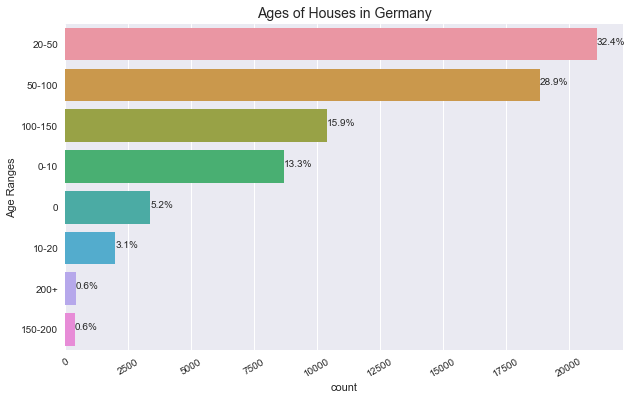

In [27]:
plt.rcParams['figure.figsize'] = [10, 6]
ax = sns.countplot(data=df_ages_viz, y='Age_Range', order=df_ages_viz.Age_Range.value_counts().index)
total = float(len(df_ages_viz))   
plt.xticks(rotation=30)
plt.title("Ages of Houses in Germany", fontsize=14)
plt.ylabel("Age Ranges")
total = len(df_ages_viz['Age_Range'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
plt.show()

Creating a new sample data with the same number of rooms to compare the states.

In [28]:
df_price_4 = named_price[(named_price.Rooms == 4)]
df_price_4 = df_price_4.reset_index(drop=True)

df_rent_4 = named_rent[(named_rent.Rooms == 4)]
df_rent_4 = df_rent_4.reset_index(drop=True)

In [29]:
df_price_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7833 entries, 0 to 7832
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   State      7833 non-null   object 
 1   Year       6606 non-null   float64
 2   Post_Code  7833 non-null   object 
 3   Rooms      7833 non-null   float64
 4   LocalArea  7833 non-null   object 
 5   Price      7833 non-null   float64
dtypes: float64(3), object(3)
memory usage: 367.3+ KB


In [30]:
df_rent_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8278 entries, 0 to 8277
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   State      8278 non-null   object 
 1   Year       6540 non-null   float64
 2   Post_Code  8278 non-null   object 
 3   Rooms      8278 non-null   float64
 4   LocalArea  8278 non-null   object 
 5   Rent       6973 non-null   float64
dtypes: float64(3), object(3)
memory usage: 388.2+ KB


In [31]:
df_dropped = df_price.drop(columns_to_drop, axis=1)

In [32]:
df_price_avg = df_price_4.groupby("State", as_index=False)["Price"].mean()
df_rent_avg = df_rent_4.groupby("State", as_index=False)["Rent"].mean()

df_price_avg = df_price_avg.sort_values(by=['Price'], ascending=False)
df_rent_avg = df_rent_avg.sort_values(by=['Rent'], ascending=False)

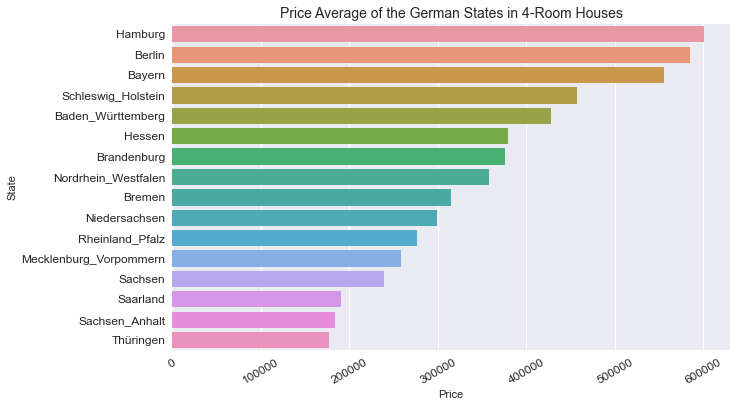

In [33]:
plt.rcParams['figure.figsize'] = [10, 6]
ax = sns.barplot(x="Price", y="State", data=df_price_avg)
plt.title("Price Average of the German States in 4-Room Houses", fontsize= 14)
plt.yticks(fontsize= 12);
plt.xticks(rotation=30, fontsize= 12);

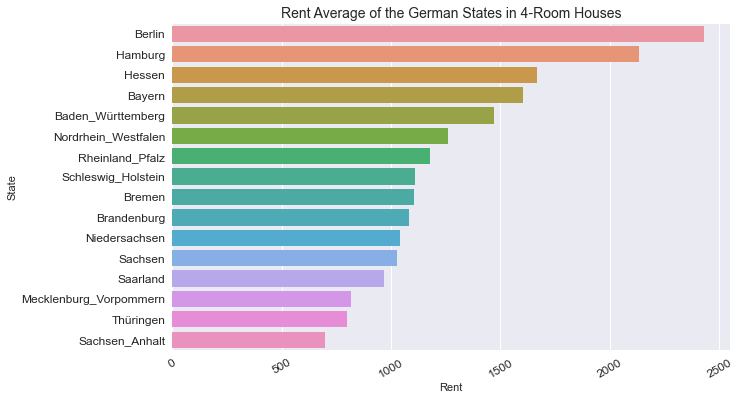

In [34]:
plt.rcParams['figure.figsize'] = [10, 6]
ax = sns.barplot(x="Rent", y="State", data=df_rent_avg)
plt.title("Rent Average of the German States in 4-Room Houses", fontsize= 14)
plt.yticks(fontsize= 12);
plt.xticks(rotation=30, fontsize= 12);

#### Lets examine house price over rents in States of Germany.

In [35]:
price_over_rent = pd.merge(
    left=df_price_avg, 
    right=df_rent_avg, 
    on='State',
    how='inner'
)


price_over_rent.head(2)

,State,Price,Rent
0,Hamburg,600185.620438,2135.152371
1,Berlin,585011.102326,2429.040462


In [36]:
'''How many years of rent corresponds to the purchase price.'''

price_over_rent['Years'] = price_over_rent['Price'] / (12 * price_over_rent['Rent'])

price_over_rent = price_over_rent.sort_values(by=['Years'])

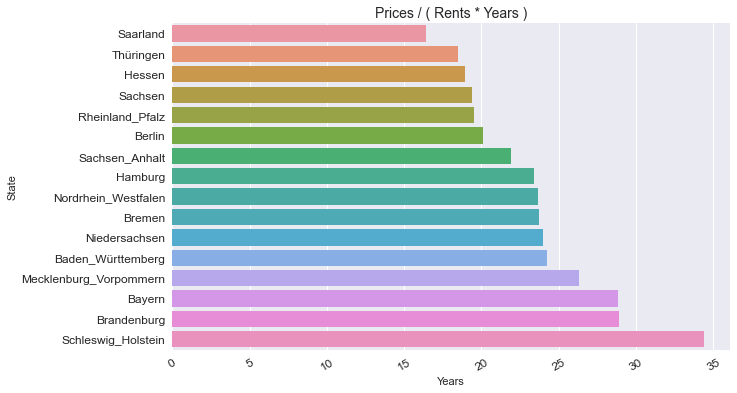

In [37]:
plt.rcParams['figure.figsize'] = [10, 6]
ax = sns.barplot(x="Years", y="State", data=price_over_rent)
plt.title("Prices / ( Rents * Years )", fontsize= 14)
plt.yticks(fontsize= 12);
plt.xticks(rotation=30, fontsize= 12);

Finding : The price of a house in Schleswig Holstein corresponds to approximately 34 years of rent, while in Saarland it corresponds to approximately 13.5 years.

#### After examining house prices in Germany, let's look at the general distribution by location on the map.

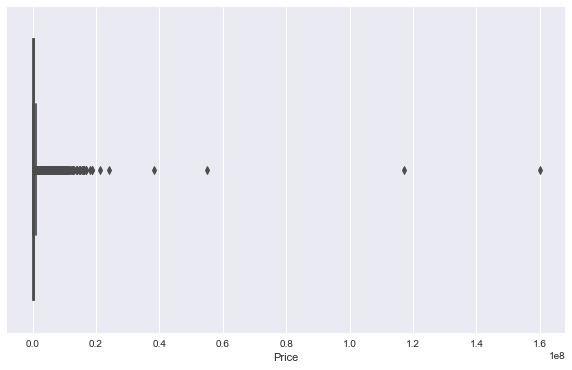

In [38]:
ax = sns.boxplot(x=named_price["Price"])

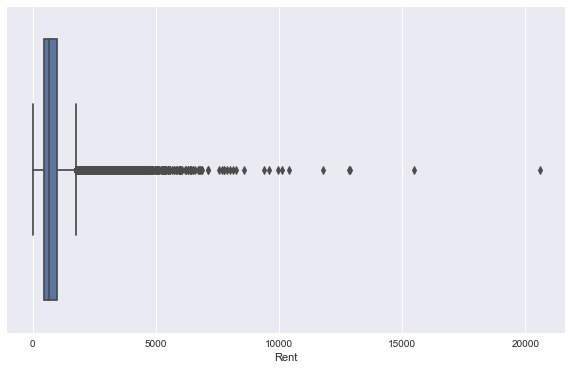

In [39]:
ax = sns.boxplot(x=named_rent["Rent"])

According to the Boxplots, that shows Price and Rent distribution, there is irrational Outlier values. Lets make them reasonable.

In [40]:
def max_outlier_setting(clmn):
    Q1 = clmn.quantile(0.25)
    Q3 = clmn.quantile(0.75)
    IQR = Q3 - Q1
    max_value = Q3 + 1.5 * IQR
    return max_value

In [41]:
price_map = named_price
rent_map = named_rent

In [42]:
price_map.Price.loc[price_map.Price > max_outlier_setting(price_map['Price'])]  = max_outlier_setting(price_map['Price'])
rent_map.Rent.loc[rent_map.Rent > max_outlier_setting(rent_map['Rent'])]  = max_outlier_setting(rent_map['Rent'])

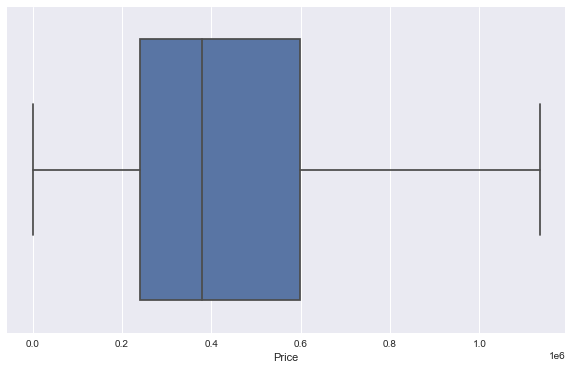

In [43]:
ax = sns.boxplot(x=price_map["Price"])

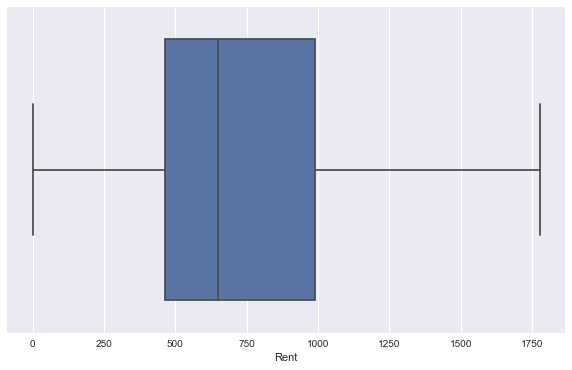

In [44]:
ax = sns.boxplot(x=rent_map["Rent"])

In [45]:
price_local = price_map[['Post_Code','Price']]
rent_local = rent_map[['Post_Code','Rent']]

price_local = price_local.groupby("Post_Code", as_index=False)["Price"].mean()
rent_local = rent_local.groupby("Post_Code", as_index=False)["Rent"].mean()

In [46]:
germany_price = pd.merge(
    left=named_shape, 
    right=price_local, 
    on='Post_Code',
    how='right'
)


germany_rent = pd.merge(
    left=named_shape, 
    right=rent_local, 
    on='Post_Code',
    how='right'
)

In [47]:
germany_price.head(3)

,Post_Code,note,geometry,Price
0,52538,"52538 Gangelt, Selfkant","POLYGON ((5.86632 51.05110, 5.86692 51.05124, ...",351843.333333
1,47559,47559 Kranenburg,"POLYGON ((5.94504 51.82354, 5.94580 51.82409, ...",453723.500000
2,52525,"52525 Waldfeucht, Heinsberg","POLYGON ((5.96811 51.05556, 5.96951 51.05660, ...",317099.681818


In [48]:
germany_rent.head(3)

,Post_Code,note,geometry,Rent
0,52538,"52538 Gangelt, Selfkant","POLYGON ((5.86632 51.05110, 5.86692 51.05124, ...",700.888889
1,47559,47559 Kranenburg,"POLYGON ((5.94504 51.82354, 5.94580 51.82409, ...",485.000000
2,52525,"52525 Waldfeucht, Heinsberg","POLYGON ((5.96811 51.05556, 5.96951 51.05660, ...",650.849600


In [49]:
# Get lat and lng of Germany's main cities. 
top_cities = {
    'Berlin': (13.404954, 52.520008), 
    'Cologne': (6.953101, 50.935173),
    'Düsseldorf': (6.782048, 51.227144),
    'Frankfurt am Main': (8.682127, 50.110924),
    'Hamburg': (9.993682, 53.551086),
    'Leipzig': (12.387772, 51.343479),
    'Munich': (11.576124, 48.137154),
    'Dortmund': (7.468554, 51.513400),
    'Stuttgart': (9.181332, 48.777128),
    'Nuremberg': (11.077438, 49.449820),
    'Hannover': (9.73322, 52.37052)
}

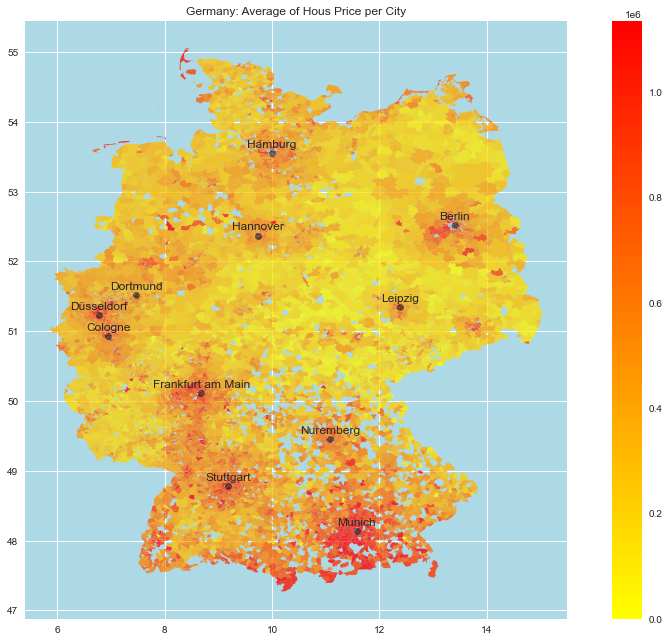

In [50]:
plt.rcParams['figure.figsize'] = [16, 11]
fig, ax = plt.subplots()

germany_price.plot(
    ax=ax, 
    column='Price', 
    categorical=False, 
    legend=True, 
    cmap='autumn_r',
    alpha=0.8
)

for c in top_cities.keys():

    ax.text(
        x=top_cities[c][0], 
        y=top_cities[c][1] + 0.08, 
        s=c, 
        fontsize=12,
        ha='center', 
    )

    ax.plot(
        top_cities[c][0], 
        top_cities[c][1], 
        marker='o',
        c='black', 
        alpha=0.5
    )
    
ax.set(
    title='Germany: Average of Hous Price per City', 
    aspect=1.3, 
    facecolor='lightblue'
);

Now Rent and Price values are appropriate.

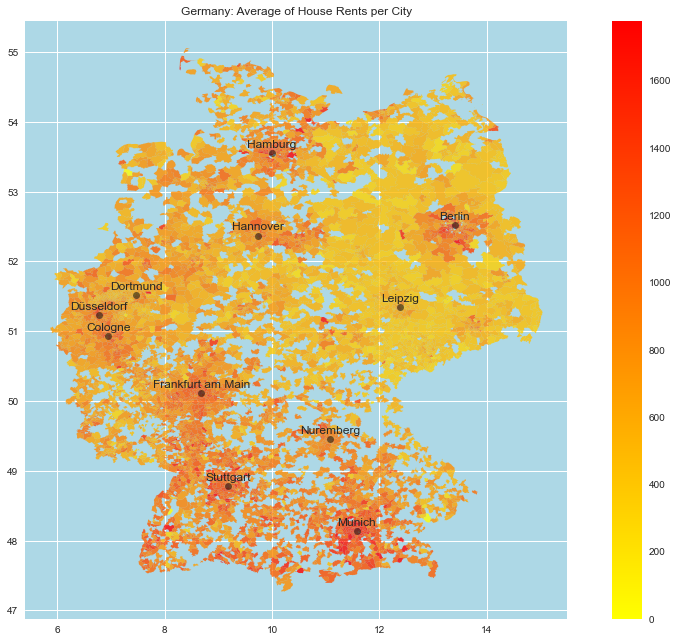

In [51]:
plt.rcParams['figure.figsize'] = [16, 11]
fig, ax = plt.subplots()

germany_rent.plot(
    ax=ax, 
    column='Rent', 
    categorical=False, 
    legend=True, 
    cmap='autumn_r',
    alpha=0.8
)

for c in top_cities.keys():

    ax.text(
        x=top_cities[c][0], 
        y=top_cities[c][1] + 0.08, 
        s=c, 
        fontsize=12,
        ha='center', 
    )

    ax.plot(
        top_cities[c][0], 
        top_cities[c][1], 
        marker='o',
        c='black', 
        alpha=0.5
    )
    
ax.set(
    title='Germany: Average of House Rents per City', 
    aspect=1.3, 
    facecolor='lightblue'
);

### Findings
Looking at the map, it can be concluded that house prices towards the South and West regions of Germany, as well as in Hamburg and Berlin, are relatively high.

It can also be said that rental prices higher around top cities.

---

## Neighborhoods and House Price Distribution in Hamburg

In [120]:
address = 'Hamburg, DE'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Hamburg are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Hamburg are 53.550341, 10.000654.


In [122]:
hamburg_price = named_price[(named_price.State == 'Hamburg')]
hamburg_rent = named_rent[(named_rent.State == 'Hamburg')]
hamburg_locals = named_locals[(named_locals.State == 'Hamburg')]

In [123]:
hamburg_price.head()

,State,Year,Post_Code,Rooms,LocalArea,Price
19,Hamburg,2009.0,22587,4.0,Blankenese,750000.0
45,Hamburg,1954.0,22045,4.0,Jenfeld,550000.0
56,Hamburg,1970.0,22043,9.0,Marienthal,1135000.0
109,Hamburg,1997.0,22547,5.0,Lurup,890000.0
606,Hamburg,1975.0,22589,6.0,Sülldorf,570000.0


In [132]:
hamburg_p_avg = hamburg_price.groupby(["Post_Code","LocalArea"], as_index=False)["Price"].mean()
hamburg_r_avg = hamburg_rent.groupby(["Post_Code"], as_index=False)["Rent"].mean()

In [133]:
hamburg_p_avg.shape

(116, 3)

In [134]:
hamburg_r_avg.shape

(100, 2)

In [135]:
hamburg_price_rent = pd.merge(
    left=hamburg_p_avg, 
    right=hamburg_r_avg, 
    on='Post_Code',
    how='left'
)

In [136]:
hamburg_price_rent = hamburg_price_rent.dropna()

In [137]:
hamburg_pr_geo = pd.merge(
    left=hamburg_locals, 
    right=hamburg_price_rent, 
    on='Post_Code',
    how='right'         
)

In [138]:
hamburg_pr_geo.head()

,Local,Post_Code,State,LocalArea,Price,Rent
0,Hamburg,20099,Hamburg,St._Georg,1135000.0,1389.601667
1,Hamburg,20146,Hamburg,Rotherbaum,1135000.0,1373.714062
2,Hamburg,20149,Hamburg,Harvestehude,1135000.0,1609.752344
3,Hamburg,20251,Hamburg,Eppendorf,1135000.0,1442.903333
4,Hamburg,21029,Hamburg,Bergedorf,830400.0,1062.343636


In [139]:
hamburg_pr_geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112 entries, 0 to 111
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Local      112 non-null    object 
 1   Post_Code  112 non-null    object 
 2   State      112 non-null    object 
 3   LocalArea  112 non-null    object 
 4   Price      112 non-null    float64
 5   Rent       112 non-null    float64
dtypes: float64(2), object(4)
memory usage: 6.1+ KB


In [140]:
de_zip_lat.head()

,zip,Lat,Lng
0,28277,53.0365574,8.8219678
1,38350,52.2430058,11.0017167
2,26131,53.1267181,8.1690126
3,26871,53.0521313,7.410425800000001
4,47809,51.3317165,6.6500224


In [141]:
de_zip_lat['zip'] = de_zip_lat['zip'].astype(str)

In [142]:
rename5 = {
         'zip':'Post_Code'
         }

zip_lat = de_zip_lat.rename(index=str, columns=rename5)

In [143]:
hamburg_df = pd.merge(
    left=hamburg_pr_geo, 
    right=zip_lat, 
    on='Post_Code',
    how='left'         
)

In [144]:
hamburg_df.head()

,Local,Post_Code,State,LocalArea,Price,Rent,Lat,Lng
0,Hamburg,20099,Hamburg,St._Georg,1135000.0,1389.601667,53.55808469999999,10.011979
1,Hamburg,20146,Hamburg,Rotherbaum,1135000.0,1373.714062,53.5688101,9.9819779
2,Hamburg,20149,Hamburg,Harvestehude,1135000.0,1609.752344,53.57762659999999,9.9908875
3,Hamburg,20251,Hamburg,Eppendorf,1135000.0,1442.903333,53.5947669,9.982104999999999
4,Hamburg,21029,Hamburg,Bergedorf,830400.0,1062.343636,53.489276,10.2260726


In [146]:
# create map of Berlin using latitude and longitude values
map_hamburg = folium.Map(location=[latitude, longitude], zoom_start=9)

# add markers to map
for lat, lng, label in zip(hamburg_df['Lat'], hamburg_df['Lng'], hamburg_df['LocalArea']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hamburg)  
    
map_hamburg

In [147]:
CLIENT_ID = 'HARRD5OFK5FRJNAHTPAQD2DQKYYV4UTI5LIDI2IF3UO1L1GR' # your Foursquare ID
CLIENT_SECRET = 'AL00RFNYU1ZCHA5RQVL2UB3TMQNQUPHR2O42HNEDQCYHAVBI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HARRD5OFK5FRJNAHTPAQD2DQKYYV4UTI5LIDI2IF3UO1L1GR
CLIENT_SECRET:AL00RFNYU1ZCHA5RQVL2UB3TMQNQUPHR2O42HNEDQCYHAVBI


In [148]:
neighborhood_latitude = hamburg_df.loc[0, 'Lat'] # neighborhood latitude value
neighborhood_longitude = hamburg_df.loc[0, 'Lng'] # neighborhood longitude value

neighborhood_name = hamburg_df.loc[0, 'LocalArea'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of St._Georg are 53.55808469999999, 10.011979.


In [149]:
# type your answer here

LIMIT = 100

radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

url

'https://api.foursquare.com/v2/venues/explore?&client_id=HARRD5OFK5FRJNAHTPAQD2DQKYYV4UTI5LIDI2IF3UO1L1GR&client_secret=AL00RFNYU1ZCHA5RQVL2UB3TMQNQUPHR2O42HNEDQCYHAVBI&v=20180605&ll=53.55808469999999,10.011979&radius=500&limit=100'

In [150]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60022708e1508a23affcd567'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'St. Georg',
  'headerFullLocation': 'St. Georg, Hamburg',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 93,
  'suggestedBounds': {'ne': {'lat': 53.56258470449999,
    'lng': 10.019540524146263},
   'sw': {'lat': 53.553584695499985, 'lng': 10.004417475853737}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b505460f964a520a22027e3',
       'name': 'cream',
       'location': {'address': 'Lange Reihe 88',
        'lat': 53.55837762561553,
        'lng': 10.012580073924072,
        'labeledLatLngs': [{'label': 'display',
          'lat': 53.558377625615

In [151]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [152]:
venues = results['response']['groups'][0]['items']

In [153]:
nearby_venues = json_normalize(venues) # flatten JSON
nearby_venues

,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.postalCode,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.location.crossStreet,venue.venuePage.id,venue.location.neighborhood
0,e-0-4b505460f964a520a22027e3-0,0,"[{'summary': 'This spot is popular', 'type': '...",4b505460f964a520a22027e3,cream,Lange Reihe 88,53.558378,10.012580,"[{'label': 'display', 'lat': 53.55837762561553...",51,20099,DE,Hamburg,Hamburg,Deutschland,"[Lange Reihe 88, 20099 Hamburg, Deutschland]","[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",0,[],NaN,NaN,NaN
1,e-0-560fc080498ec183e48642db-1,0,"[{'summary': 'This spot is popular', 'type': '...",560fc080498ec183e48642db,Neumann's Bistro & Weinbar,Lange Reihe 101,53.559050,10.013028,"[{'label': 'display', 'lat': 53.55904999481806...",127,20099,DE,Hamburg,Hamburg,Deutschland,"[Lange Reihe 101 (Schmilinskystrasse), 20099 H...","[{'id': '4bf58dd8d48988d123941735', 'name': 'W...",0,[],Schmilinskystrasse,NaN,NaN
2,e-0-56e43e5e498e0ee2d01e7aab-2,0,"[{'summary': 'This spot is popular', 'type': '...",56e43e5e498e0ee2d01e7aab,Luicella's,Lange Reihe 113,53.559663,10.014307,"[{'label': 'display', 'lat': 53.55966336021095...",233,20099,DE,Hamburg,Hamburg,Deutschland,"[Lange Reihe 113, 20099 Hamburg, Deutschland]","[{'id': '4bf58dd8d48988d1c9941735', 'name': 'I...",0,[],NaN,NaN,NaN
3,e-0-50d4507ce4b038b59ee6eb52-3,0,"[{'summary': 'This spot is popular', 'type': '...",50d4507ce4b038b59ee6eb52,EDEKA Niemerszein,Lange Reihe 110,53.559524,10.014282,"[{'label': 'display', 'lat': 53.55952394205088...",221,20099,DE,Hamburg,Hamburg,Deutschland,"[Lange Reihe 110, 20099 Hamburg, Deutschland]","[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",0,[],NaN,554910653,NaN
4,e-0-4b58b37bf964a5206b6628e3-4,0,"[{'summary': 'This spot is popular', 'type': '...",4b58b37bf964a5206b6628e3,Frau Möller,Lange Reihe 96,53.558852,10.013242,"[{'label': 'display', 'lat': 53.55885232822514...",119,20099,DE,Hamburg,Hamburg,Deutschland,"[Lange Reihe 96, 20099 Hamburg, Deutschland]","[{'id': '4bf58dd8d48988d11b941735', 'name': 'P...",0,[],NaN,NaN,NaN
5,e-0-4db8177cfa8c377d83b6901e-5,0,"[{'summary': 'This spot is popular', 'type': '...",4db8177cfa8c377d83b6901e,Alsterufer,An der Alster,53.560386,10.011120,"[{'label': 'display', 'lat': 53.56038604308977...",262,20099,DE,Hamburg,Hamburg,Deutschland,"[An der Alster, 20099 Hamburg, Deutschland]","[{'id': '4bf58dd8d48988d159941735', 'name': 'T...",0,[],NaN,NaN,NaN
6,e-0-4e7e05ceb8034ec567987cd2-6,0,"[{'summary': 'This spot is popular', 'type': '...",4e7e05ceb8034ec567987cd2,Hacker-Pschorr Hamburg,Lange Reihe 97,53.558918,10.013145,"[{'label': 'display', 'lat': 53.55891842977392...",120,20099,DE,Hamburg,Hamburg,Deutschland,"[Lange Reihe 97, 20099 Hamburg, Deutschland]","[{'id': '56aa371ce4b08b9a8d573572', 'name': 'B...",0,[],NaN,NaN,NaN
7,e-0-58382eb26d63256686c96ed8-7,0,"[{'summary': 'This spot is popular', 'type': '...",58382eb26d63256686c96ed8,Gao kitchen,Lange Reihe 81,53.558154,10.012117,"[{'label': 'display', 'lat': 53.55815400929759...",11,20099,DE,Hamburg,Hamburg,Deutschland,"[Lange Reihe 81, 20099 Hamburg, Deutschland]","[{'id': '4bf58dd8d48988d14a941735', 'name': 'V...",0,[],NaN,NaN,NaN
8,e-0-4b058858f964a5205cbf22e3-8,0,"[{'summary': 'This spot is popular', 'type': '...",4b058858f964a5205cbf22e3,Hotel Wedina,Gurlittstrasse 23,53.558267,10.009577,"[{'label': 'display', 'lat': 53.558267, 'lng':...",160,20099,DE,Hamburg,Hamburg,Deutschland,"[Gurlittstrasse 23, 20099 Hamburg, Deutschland]","[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",0,[],NaN,NaN,NaN
9,e-0-4b058864f964a5201bc322e3-9,0,"[{'summary': 'This spot is popular', 'type': '...",4b058864f964a5201bc322e3,Lagerhaus,Lange Reihe 27,53.556416,10.009858,"[{'label': 'display', 'lat'

In [154]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories','venue.location.lat','venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,cream,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",53.558378,10.012580
1,Neumann's Bistro & Weinbar,"[{'id': '4bf58dd8d48988d123941735', 'name': 'W...",53.559050,10.013028
2,Luicella's,"[{'id': '4bf58dd8d48988d1c9941735', 'name': 'I...",53.559663,10.014307
3,EDEKA Niemerszein,"[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",53.559524,10.014282
4,Frau Möller,"[{'id': '4bf58dd8d48988d11b941735', 'name': 'P...",53.558852,10.013242
5,Alsterufer,"[{'id': '4bf58dd8d48988d159941735', 'name': 'T...",53.560386,10.011120
6,Hacker-Pschorr Hamburg,"[{'id': '56aa371ce4b08b9a8d573572', 'name': 'B...",53.558918,10.013145
7,Gao kitchen,"[{'id': '4bf58dd8d48988d14a941735', 'name': 'V...",53.558154,10.012117
8,Hotel Wedina,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",53.558267,10.009577
9,Lagerhaus,"[{'id': '4bf58dd8d48988d1f6941735', 'name': 'D...",53.556416,10.009858


In [155]:
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,cream,Clothing Store,53.558378,10.012580
1,Neumann's Bistro & Weinbar,Wine Bar,53.559050,10.013028
2,Luicella's,Ice Cream Shop,53.559663,10.014307
3,EDEKA Niemerszein,Supermarket,53.559524,10.014282
4,Frau Möller,Pub,53.558852,10.013242


In [156]:
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,cream,Clothing Store,53.558378,10.012580
1,Neumann's Bistro & Weinbar,Wine Bar,53.559050,10.013028
2,Luicella's,Ice Cream Shop,53.559663,10.014307
3,EDEKA Niemerszein,Supermarket,53.559524,10.014282
4,Frau Möller,Pub,53.558852,10.013242


In [157]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

93 venues were returned by Foursquare.


In [158]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [159]:
hamburg_venues = getNearbyVenues(names=hamburg_df['LocalArea'],
                                   latitudes=berlin_df['Lat'],
                                   longitudes=berlin_df['Lng']
                                  )

St._Georg
Rotherbaum
Harvestehude
Eppendorf
Bergedorf
Lohbrügge
Lohbrügge
Bergedorf
Allermöhe
Kirchwerder
Neuengamme
Ochsenwerder
Curslack
Neuengamme
Harburg
Eißendorf
Heimfeld
Eißendorf
Marmstorf
Wilstorf
Harburg
Heimfeld
Langenbek
Rönneburg
Sinstorf
Wilstorf
Wilhelmsburg
Finkenwerder
Neuenfelde
Hausbruch
Neugraben_Fischbek
Hausbruch
Marmstorf
Neugraben_Fischbek
Marienthal
Wandsbek
Jenfeld
Marienthal
Jenfeld
Tonndorf
Tonndorf
Barmbek_Süd
Marienthal
Uhlenhorst
Eilbek
Billstedt
Horn
Billstedt
Billstedt
Rahlstedt
Bramfeld
Rahlstedt
Rahlstedt
Neugraben_Fischbek
Rahlstedt
Farmsen_Berne
Bramfeld
Schnelsen
Barmbek_Nord
Bramfeld
Alsterdorf
Fuhlsbüttel
Ohlsdorf
Fuhlsbüttel
Hummelsbüttel
Bergstedt
Rahlstedt
Volksdorf
Poppenbüttel
Wellingsbüttel
Sasel
Wellingsbüttel
Winterhude
Bergstedt
Sasel
Volksdorf
Duvenstedt
Lemsahl_Mellingstedt
Wohldorf_Ohlstedt
Lemsahl_Mellingstedt
Poppenbüttel
Langenhorn
Langenhorn
Langenhorn
Groß_Borstel
Niendorf
Niendorf
Rahlstedt
Schnelsen
Niendorf
Schnelsen
Eidelsted

In [160]:
print(hamburg_venues.shape)
hamburg_venues.head()

(1550, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,St._Georg,52.530741,13.4058114,A.D. Deertz,52.529430,13.403470,Men's Store
1,St._Georg,52.530741,13.4058114,Cafe Galão,52.531120,13.402516,Café
2,St._Georg,52.530741,13.4058114,Zeit für Brot,52.530394,13.401852,Bakery
3,St._Georg,52.530741,13.4058114,Gorki Apartments,52.530671,13.401450,Vacation Rental
4,St._Georg,52.530741,13.4058114,St. Oberholz Coffee Lab,52.529699,13.407446,Coffee Shop


In [161]:
print('There are {} uniques categories.'.format(hamburg_venues['Venue Category'].nunique()))

There are 275 uniques categories.


In [162]:
# one hot encoding
hamburg_onehot = pd.get_dummies(hamburg_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hamburg_onehot['Neighborhood'] = hamburg_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [hamburg_onehot.columns[-1]] + list(hamburg_onehot.columns[:-1])
hamburg_onehot = hamburg_onehot[fixed_columns]

hamburg_onehot.head()

,Neighborhood,ATM,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Bavarian Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Boarding House,Boat Rental,Bookstore,Bosnian Restaurant,Boutique,Bowling Alley,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Stop,Cable Car,Cafeteria,Café,Candy Store,Cantonese Restaurant,Carpet Store,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Currywurst Joint,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Shop,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hockey Rink,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Italian Restaurant,Japanese Restaurant,Jazz Club,Karaoke Bar,Kofte Place,Korean Restaurant,Kumpir Restaurant,Lake,Laser Tag,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Liquor Store,Lottery Retailer,Lounge,Market,Martial Arts School,Massage Studio,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Modern European Restaurant,Moroccan Restaurant,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Museum,Music Store,Nail Salon,Nature Preserve,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Pakistani Restaurant,Park,Pastry Shop,Pedestrian Plaza,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Piano Bar,Piercing Parlor,Pizza Place,Playground,Plaza,Pool,Post Office,Print Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,River,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,South Indian Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Squash Court,Stadium,Stationery Store,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Swabian Restaurant,Syrian Restaurant,Szechuan Restaurant,Tailor Shop,Tanning Salon,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Tibetan Restaurant,Tour Provider,Tourist Information Center,Trail,Train Station,Tram Station,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vacation Rental,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo,Zoo Exhibit
0,St._Georg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [163]:
hamburg_onehot.shape

(1550, 276)

In [165]:
hamburg_grouped = hamburg_onehot.groupby('Neighborhood').mean().reset_index()
hamburg_grouped.head(2)

,Neighborhood,ATM,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Bavarian Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Boarding House,Boat Rental,Bookstore,Bosnian Restaurant,Boutique,Bowling Alley,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Stop,Cable Car,Cafeteria,Café,Candy Store,Cantonese Restaurant,Carpet Store,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Currywurst Joint,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Shop,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hockey Rink,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Italian Restaurant,Japanese Restaurant,Jazz Club,Karaoke Bar,Kofte Place,Korean Restaurant,Kumpir Restaurant,Lake,Laser Tag,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Liquor Store,Lottery Retailer,Lounge,Market,Martial Arts School,Massage Studio,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Modern European Restaurant,Moroccan Restaurant,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Museum,Music Store,Nail Salon,Nature Preserve,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Pakistani Restaurant,Park,Pastry Shop,Pedestrian Plaza,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Piano Bar,Piercing Parlor,Pizza Place,Playground,Plaza,Pool,Post Office,Print Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,River,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,South Indian Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Squash Court,Stadium,Stationery Store,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Swabian Restaurant,Syrian Restaurant,Szechuan Restaurant,Tailor Shop,Tanning Salon,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Tibetan Restaurant,Tour Provider,Tourist Information Center,Trail,Train Station,Tram Station,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vacation Rental,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo,Zoo Exhibit
0,Allermöhe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.

In [167]:
hamburg_grouped.shape

(65, 276)

In [261]:
num_top_venues = 5

for hood in hamburg_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = hamburg_grouped[hamburg_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allermöhe----
                  venue  freq
0             Nightclub  0.25
1    Italian Restaurant  0.12
2             Laser Tag  0.12
3         Big Box Store  0.12
4  Gym / Fitness Center  0.12


----Alsterdorf----
              venue  freq
0       Supermarket   0.2
1  Greek Restaurant   0.2
2      Tram Station   0.2
3    Ice Cream Shop   0.2
4    Cosmetics Shop   0.2


----Bahrenfeld----
                venue  freq
0         Coffee Shop  0.14
1   German Restaurant  0.14
2                Café  0.14
3              Museum  0.14
4  Italian Restaurant  0.07


----Barmbek_Nord----
                venue  freq
0  Italian Restaurant   0.2
1        Liquor Store   0.2
2           Cable Car   0.2
3          Playground   0.2
4              Garden   0.2


----Barmbek_Süd----
                         venue  freq
0  Eastern European Restaurant   0.2
1                 Soccer Field   0.2
2                    Mini Golf   0.2
3                     Bus Stop   0.2
4           Chinese Restaurant   0.2



                venue  freq
0  Italian Restaurant  0.17
1      Farmers Market  0.17
2     Organic Grocery  0.17
3                Lake  0.17
4               Plaza  0.17


----Ottensen----
                venue  freq
0  Italian Restaurant  0.18
1      Ice Cream Shop  0.12
2           Drugstore  0.12
3                Bank  0.12
4              Bakery  0.06


----Poppenbüttel----
                venue  freq
0         Supermarket  0.33
1           Drugstore  0.11
2          Theme Park  0.11
3  Chinese Restaurant  0.11
4         Pizza Place  0.11


----Rahlstedt----
          venue  freq
0   Supermarket  0.18
1      Bus Stop  0.11
2  Tram Station  0.11
3        Forest  0.07
4           ATM  0.04


----Rissen----
                    venue  freq
0  Furniture / Home Store  0.17
1                   Hotel  0.17
2    Fast Food Restaurant  0.08
3           Big Box Store  0.08
4              Restaurant  0.08


----Rotherbaum----
               venue  freq
0        Coffee Shop  0.07
1     Clothing Sto

In [262]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [263]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = hamburg_grouped['Neighborhood']

for ind in np.arange(hamburg_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hamburg_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allermöhe,Nightclub,Italian Restaurant,Gym / Fitness Center,Ski Area,Laser Tag,Big Box Store,Bowling Alley,Food Truck,Food Court,Food & Drink Shop
1,Alsterdorf,Supermarket,Ice Cream Shop,Cosmetics Shop,Greek Restaurant,Tram Station,Zoo Exhibit,Filipino Restaurant,Falafel Restaurant,Farm,Farmers Market
2,Bahrenfeld,German Restaurant,Museum,Coffee Shop,Café,Italian Restaurant,Asian Restaurant,Park,Restaurant,Trail,Indie Movie Theater
3,Barmbek_Nord,Italian Restaurant,Liquor Store,Playground,Cable Car,Garden,IT Services,Hotel Bar,Forest,Food Truck,Food Court
4,Barmbek_Süd,Mini Golf,Chinese Restaurant,Soccer Field,Eastern European Restaurant,Bus Stop,Fish Market,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Zoo Exhibit


## Clustering 

Find optimum number of Cluster with Elbow Method

In [264]:
# set number of clusters
kclusters = 5

hamburg_grouped_clustering = hamburg_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hamburg_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 4, 1, 1], dtype=int32)

In [265]:
hamburg_df.head()

,Local,Post_Code,State,LocalArea,Price,Rent,Lat,Lng
0,Hamburg,20099,Hamburg,St._Georg,1135000.0,1389.601667,53.55808469999999,10.011979
1,Hamburg,20146,Hamburg,Rotherbaum,1135000.0,1373.714062,53.5688101,9.9819779
2,Hamburg,20149,Hamburg,Harvestehude,1135000.0,1609.752344,53.57762659999999,9.9908875
3,Hamburg,20251,Hamburg,Eppendorf,1135000.0,1442.903333,53.5947669,9.982104999999999
4,Hamburg,21029,Hamburg,Bergedorf,830400.0,1062.343636,53.489276,10.2260726


In [266]:
hamburg_neighborhood = hamburg_df.rename(columns={"LocalArea": "Neighborhood"})

In [268]:
# neighborhoods_venues_sorted.drop('Cluster Labels', axis='columns', inplace=True )

In [269]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

hamburg_merged = hamburg_neighborhood

# merge hamburg_grouped with hamburg_data to add latitude/longitude for each neighborhood
hamburg_merged = hamburg_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

hamburg_merged.head(3) # check the last columns!

,Local,Post_Code,State,Neighborhood,Price,Rent,Lat,Lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hamburg,20099,Hamburg,St._Georg,1135000.0,1389.601667,53.55808469999999,10.011979,1.0,Bar,Coffee Shop,Italian Restaurant,Vietnamese Restaurant,Bakery,Café,Vegetarian / Vegan Restaurant,Plaza,Hostel,Bookstore
1,Hamburg,20146,Hamburg,Rotherbaum,1135000.0,1373.714062,53.5688101,9.9819779,1.0,Coffee Shop,Clothing Store,Hotel,Optical Shop,Gym / Fitness Center,Ice Cream Shop,Restaurant,Vietnamese Restaurant,Plaza,German Restaurant
2,Hamburg,20149,Hamburg,Harvestehude,1135000.0,1609.752344,53.57762659999999,9.9908875,1.0,Pizza Place,Café,Bar,Italian Restaurant,Vietnamese Restaurant,Hotel,Falafel Restaurant,Indian Restaurant,Bakery,Food & Drink Shop


In [270]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [271]:
hamburg_merged = hamburg_merged.dropna()

In [272]:
hamburg_merged['Cluster Labels'] = hamburg_merged['Cluster Labels'].astype(int)

In [273]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hamburg_merged['Lat'], hamburg_merged['Lng'], hamburg_merged['Neighborhood'], hamburg_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters